In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, MiniBatchSparsePCA, TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

In [2]:
df = pd.read_pickle('FT-data-DSpace/data_agreggated.pickle')
df = df[['Date', 'Meeting Number', 'Clean']]

In [3]:
df['Sentences'] = df['Clean'].apply(lambda x: ' '.join(x))
df['Date'] = pd.to_datetime(df['Date'])
df.sample(2)

,Date,Meeting Number,Clean,Sentences
474,2014-01-15 13:00:00,39. møde,"[mød, åbn, folketing, dagsord, dag, følg, medd...",mød åbn folketing dagsord dag følg meddel mini...
832,2017-03-21 13:00:00,70. møde,"[mød, åbn, tirsdag, mart, folketing, dagsord, ...",mød åbn tirsdag mart folketing dagsord kan med...


In [4]:
#tvec = TfidfVectorizer(min_df=.01, max_df=1.0, sublinear_tf=True, analyzer='word', ngram_range=(1,2), max_features=20000)
tvec = TfidfVectorizer(analyzer='word', ngram_range=(1,1), max_features=10000,  
                       min_df=10, max_df=0.7, sublinear_tf=True)
x = tvec.fit_transform(df['Sentences'])

words = tvec.get_feature_names()

In [5]:
df_x = pd.DataFrame(columns= words, data=x.toarray())
df_x['Date'] = df['Date']
df_x['Year'] = df_x['Date'].dt.year
df_x['Meeting'] = df['Meeting Number']
df_x.sample(2)

,3f,a4,aabenraa,aaen,aaja,aalborg,aamund,aarhus,aastrup,abba,...,østjylland,østjysk,østr,østrigsk,øve,øvels,øverst,Date,Year,Meeting
375,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2013-02-05 13:00:00,2013,55. møde
853,0.0,0.024975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022025,0.0,0.0,0.0,0.0,0.0,0.015302,2017-05-03 13:00:00,2017,91. møde


### PCA

Performing dimensionality reduction using LSA
done in 88.354880s


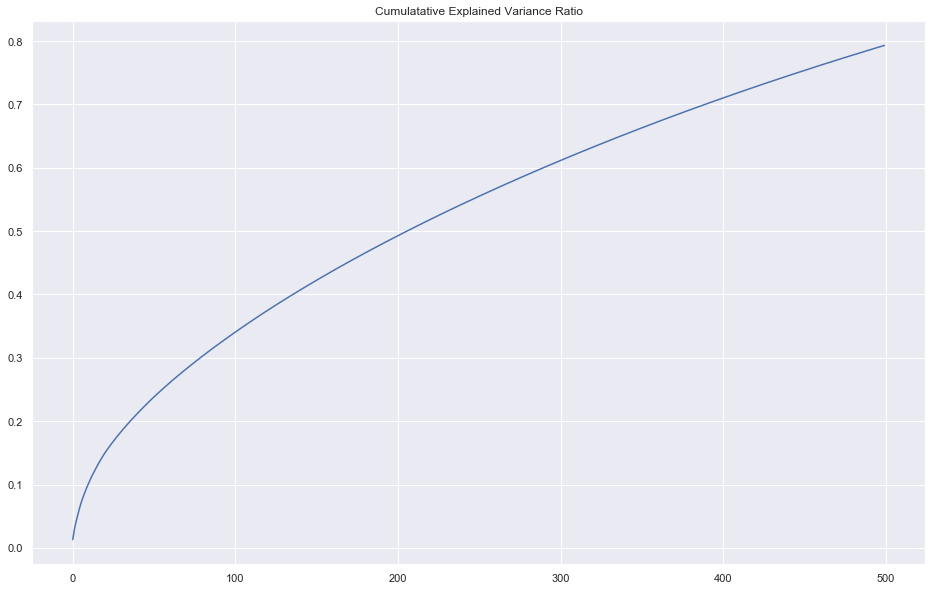

In [6]:
print("Performing dimensionality reduction using LSA")
t0 = time.time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(n_components=500, n_iter=100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

pca_result = lsa.fit_transform(df_x[words])
df_x['pca-one'] = pca_result[:,0]
df_x['pca-two'] = pca_result[:,1] 
df_x['pca-three'] = pca_result[:,2]#

print("done in %fs" % (time.time() - t0))
plt.figure(figsize=(16,10))
plt.title('Cumulatative Explained Variance Ratio')
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.show()

In [ ]:
#pca = TruncatedSVD(n_components=700, n_iter=10) ## latent semantic analysis (LSA)
#pca_result = pca.fit_transform(df_x[words].values)
#pca_result = normalize(pca_result)
#df_x['pca-one'] = pca_result[:,0]
#df_x['pca-two'] = pca_result[:,1] 
#df_x['pca-three'] = pca_result[:,2]#


In [ ]:
### you can skip the elbow method

In [ ]:
#Code For Elbow Method
nc = range(40,70,5)
kmeans = [KMeans(n_clusters = i, n_init = 10, max_iter = 100, algorithm='full') for i in nc]
score = [kmeans[i].fit(pca_result).inertia_ for i in range(len(kmeans))]
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show() ## to find the most optimal K -> optimal K is when the graph levels off


In [60]:
k = 10
#kmeans = KMeans(n_clusters=3).fit(df_x[words])
kmeans = KMeans(n_clusters=k, n_init=10, max_iter=2000, algorithm='full').fit(pca_result)
df_x['label'] = kmeans.labels_

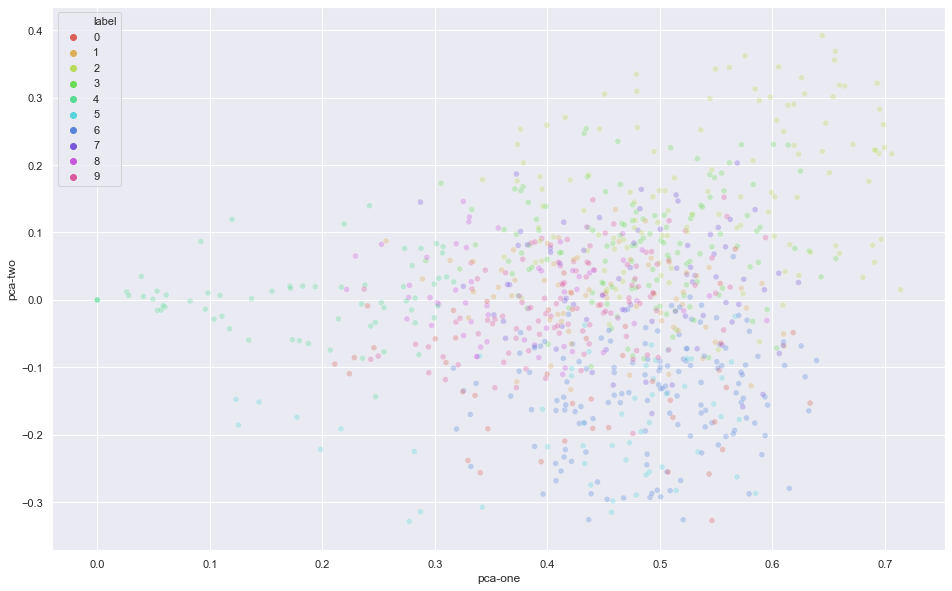

In [61]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

#### T-SNE

In [62]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000)
#tsne_results = tsne.fit_transform(df_x[words])
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.086s...
[t-SNE] Computed neighbors for 863 samples in 0.608s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 0.295880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 159.161560
[t-SNE] KL divergence after 1000 iterations: 3.105813
t-SNE done! Time elapsed: 4.813013553619385 seconds


In [63]:
df_x['tsne_component_one'] = tsne_results[:,0]
df_x['tsne_component_two'] = tsne_results[:,1]

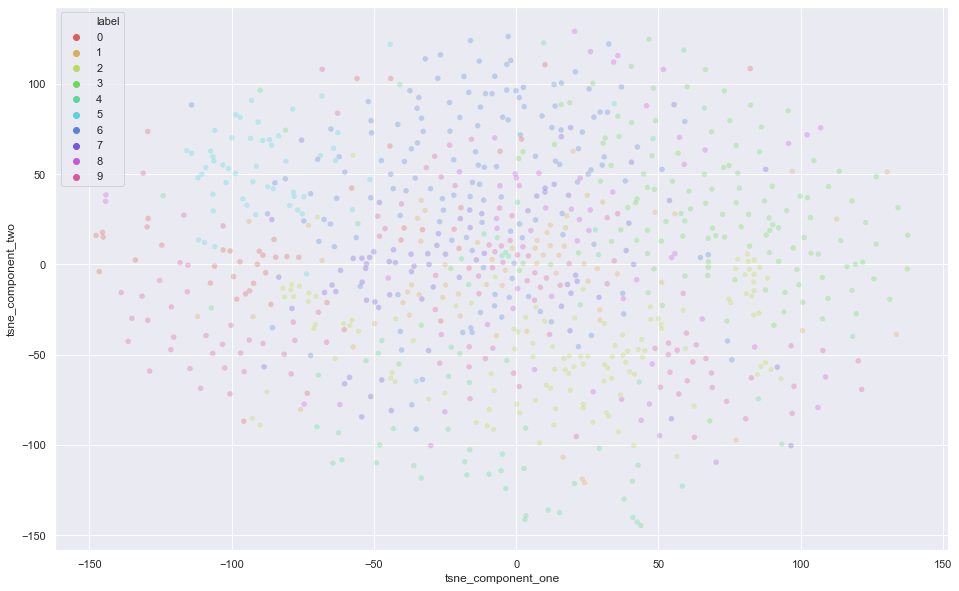

In [64]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_component_one", y="tsne_component_two",
    hue='label',
    palette=sns.color_palette("hls", k),
    data=df_x,
    legend="full",
    alpha=0.3
)

<Figure size 1152x720 with 0 Axes>

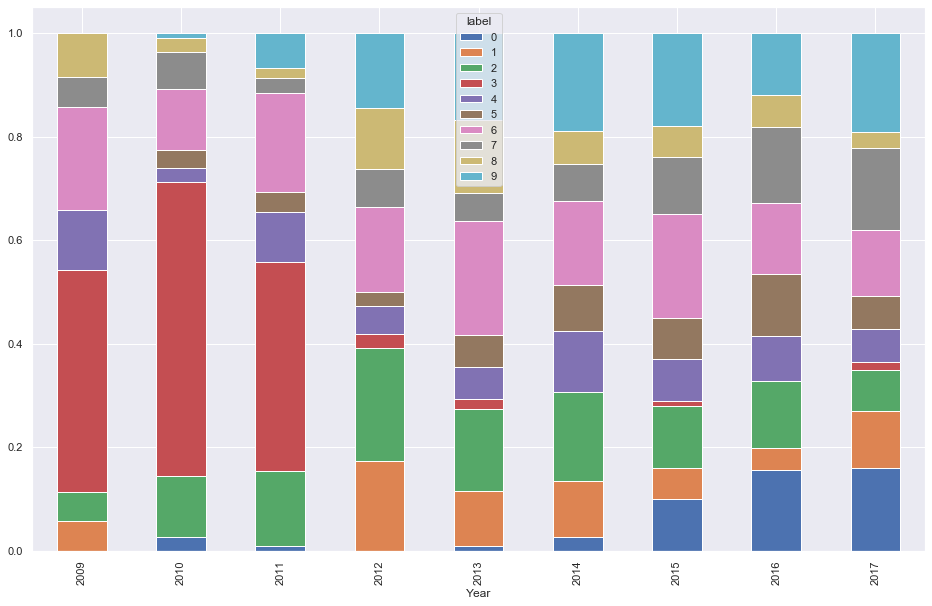

In [65]:
plt.figure(figsize=(16,10))
df_ = df_x.groupby(['Year', 'label'])['Meeting'].count().unstack()
df_ = df_.div(df_.sum(axis=1),axis=0).plot(kind='bar', stacked=True,  figsize=(16,10))
plt.show()

In [66]:
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [67]:
terms = tvec.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: flygtning asylansøg knuth marcus asyl integration johan integrationsyd sofi opholdstillad
Cluster 1: elev folkeskol undervisning ahrendts alex forældr rosa meret riisag dohn
Cluster 2: arbejdsløs skattelet dagpeng kontanthjælp reform skattereform dagpengeperiod dagpengesystem oles forsørg
Cluster 3: barfod lausts per anders lin bjarn indenr region sundhedsminist sophi
Cluster 4: onsdag kong ændringsforslag oktob nyvalg august grønland færø kf udvalgsbehandling
Cluster 5: udenrigsminist militær isil irak syri fn civil soldat nato krig
Cluster 6: justitsminist politi kriminalit kriminel domstol forbryd straf forslagsstil behnk fængsel
Cluster 7: co2 fossil omstilling energi pso vedvar grøn energipolitik udledning klima
Cluster 8: patient sundhedsvæs sundhedsvæsen sundhedsstyr region sophi sygdom ændringsforslag sundhedsminist blixt
Cluster 9: medspørg justitsminist transportminist politi oplæsning skatteminist finansminist pet skaarup spørgetid


In [68]:
#### make per meeting agenda